#**Deteção de Anomalias em Folhas de Alfaces**

***Rúben Barbosa, up202102684***

** **

**Contexto**

Na tese, será desenvolvido um protótipo de uma estufa para o controlo e monitorização de uma plantação de alfaces. Um dos módulos constituintes das estufa é uma câmara que retira imagens individuais das alfaces para análise da sua condição de saúde. Assim, a proposta para este projeto passa por detetar anomalias em alfaces, sejam partes de folhas podres, deficiências no crescimento ou fungos.

Deste modo, o projeto foi dividido em duas partes:
- Parte 1 - Classificação em duas classes, Saudável e Não Saudável;
- Parte 2 - Classificação em 6 classes, Healthy, Downy Mildew, Bacterial, Powdery Mildew, Septoria Blight, Wilt and Leaf Blight;

** **

**Modelo**

De acordo com o artigo 1, o uso do modelo Resnet50 conseguiu uma accuracy de 99,8% com o dataset PlantVillage para a deteção de várias doenças em diferentes plantas. Este artigo refere-se à deteção de anomalias em diferentes plantas, porém, e com o trabalho desenvolvido neste projeto, provou-se que o mesmo modelo tem uma ótima performance para a deteção de anomalias em folhas de alfaces.

** **

**Avaliação do Algoritmo**

Propõem-se assim classificar alfaces saudáveis de não saudáveis (Parte 1), classificar alfaces em Healthy, Downy Mildew, Bacterial, Powdery Mildew, Septoria Blight, Wilt and Leaf Blight (Parte 2).

** **
**Dataset**

O dataset a ser usado, referido na proposta do projeto (dataset 1), é constituído por um número baixo de imagens, (118) o que levou ao uso recorrente de Data Augmentation para aumentar o tamanho deste. Outro problema que este dataset possui é o número desigual de imagens entre classes (Saudável e não Saudável). Para isso, e para a parte 1 do projeto alinea b, foram fundidos dois datasets para que exista um número idêntico de alfaces saudáveis de não saudáveis (118 + 84). Assim, passou a ser composto por 104 imagens de alfaces saudáveis e 98 alfaces com anomalias. Para a parte 2 foi apenas utilizado o dataset 1. Para distinguir as classes foram criados dois ficheiros csv: 'Lettuces 2 Classes.csv' composto por 2 labels para 202 imagens (parte 1), 'Lettuces 5 Classes.csv' composto por 5 labels para 118 imagens (parte 2).

Dataset 1 - https://github.com/chandru11235/Lettuce-plant-leaf-Datasets (118 imagens; Healthy, Downy Mildew, Bacterial, Powdery Mildew, Septoria Blight, Wilt and Leaf Blight)

Dataset 2 - https://images.cv/dataset/lettuce-image-classification-dataset (84 imagens saudáveis de alfaces)






In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD, NAdam
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
import os
import pandas as pd
from skimage import io
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [ ]:
#create dataset class

class LettuceDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform):
        self.annotations = pd.read_csv(csv_file, sep = ',', header = None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        t = transforms.Resize((500,500))
        image = t(image)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module, 
          dataloader: torch.utils.data.DataLoader, 
          loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_cicles,
          num_epochs, 
          path_model,
          verbatim):
  
    model.train()
    model.to(device)

    log_train_loss.clear()
    log_train_acc.clear()


    for cicle in range(num_cicles):
        print("----------------- Cicle ", cicle, " of ", num_cicles, " -----------------")
        best_accuracy = 0.0
        best_loss = 0.0
        best_epoch = 0

        for epoch in range(num_epochs):  # loop over the dataset multiple times
            print("----------------- Epoch ", epoch, " of ", num_epochs, " -----------------")

            train_acc = 0.0
            train_loss = 0.0
            for ibatch, (images, labels) in enumerate(dataloader, 0):
                
                # get the inputs
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))
                
                # 1. Forward pass
                y_pred = model(images)

                # 2. Calculate  and accumulate loss
                loss = loss_fn(y_pred, labels)
                train_loss += loss.item() 

                # 3. Optimizer zero grad
                optimizer.zero_grad()

                # 4. Loss backward
                loss.backward()

                # 5. Optimizer step
                optimizer.step()

                # Calculate and accumulate accuracy metric across all batches
                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

            # Adjust metrics to get average loss and accuracy per batch 
            train_loss = train_loss / len(dataloader)
            train_acc = train_acc / len(dataloader)

            log_train_loss.append(train_loss)
            log_train_acc.append(train_acc)

            print("Train Loss: ", train_loss, "Train Accuracy: ", train_acc)

            path = "./myModel_" + str(epoch) + ".pth"
            #saveModel(model, path = path)

            if train_acc > best_accuracy:
                path = str(path_model)
                saveModel(model, path = path)
                best_loss = train_loss
                best_accuracy = train_acc
                best_epoch = epoch

    return best_loss, best_accuracy, best_epoch

In [ ]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module, 
         dataloader: torch.utils.data.DataLoader, 
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):
    
    # Put model in eval mode
    model.eval()

    log_val_loss.clear()
    log_val_acc.clear()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

            log_val_loss.append(test_loss / len(dataloader))
            log_val_acc.append(test_acc / len(dataloader))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


In [ ]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():

        for (x, y) in iterator:
            x = x.to(device)
            y_pred  = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs


def plot_confusion_matrix(labels, pred_labels,classess):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classess)
    cm.plot(values_format='d', cmap='Blues', ax=ax)

**Parte 1**

**Classificação de Alface em Saudável e Não Saudável**

Foi utilizado o Resnet50 como modelo para a rede, com cross entropy para cálculo da loss e SGD como optimizer. É utilizado o modelo pretreinado, com os pesos já pre definidos. No treino desta rede com este dataset, os pesos serão ajustados para que tenha um desempenho adequado ao dataset.

--------------------Training----------------------
----------------- Cicle  0  of  1  -----------------
----------------- Epoch  0  of  10  -----------------
Train Loss:  5.938122297588148 Train Accuracy:  0.24345479082321186
----------------- Epoch  1  of  10  -----------------
Train Loss:  1.946332363705886 Train Accuracy:  0.8234817813765183
----------------- Epoch  2  of  10  -----------------
Train Loss:  0.7754307302989458 Train Accuracy:  0.8275303643724697
----------------- Epoch  3  of  10  -----------------
Train Loss:  0.26642510138059916 Train Accuracy:  0.9222672064777329
----------------- Epoch  4  of  10  -----------------
Train Loss:  0.09667574761337355 Train Accuracy:  0.9719298245614036
----------------- Epoch  5  of  10  -----------------
Train Loss:  0.053412123191121375 Train Accuracy:  0.9894736842105264
----------------- Epoch  6  of  10  -----------------
Train Loss:  0.07740651816129684 Train Accuracy:  0.9784075573549259
----------------- Epoch  7  of  10  --

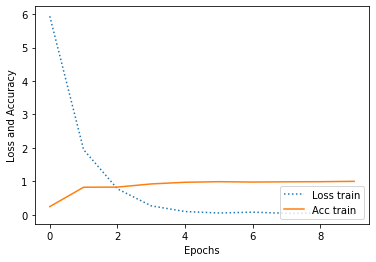

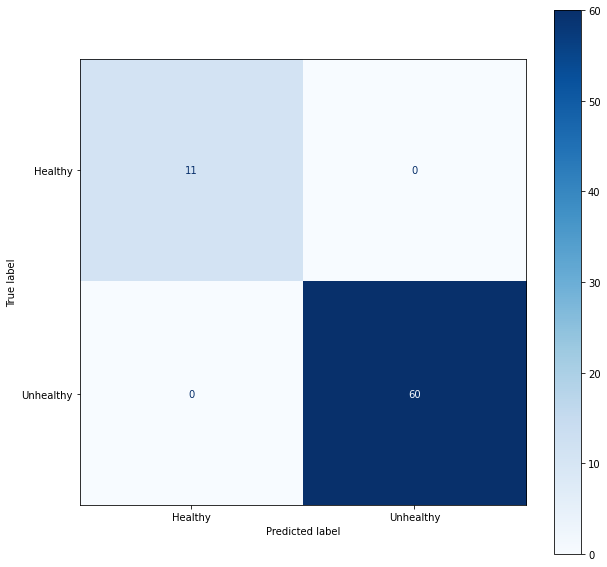

In [ ]:
#utilizar dataset 1 para mostrar o peso de possuir muitas imagens não saudáveis
#A

#arrays to log data
log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

learning_rate = 1e-3
batch_size = 15
num_cicles = 1
num_epochs = 10

#transform to random rotate
transformsRotation = transforms.Compose([
  transforms.RandomRotation(degrees=(-90, 90)),
  transforms.ToTensor()
])
#transform to add blur
transformsBlur = transforms.Compose([
  transforms.GaussianBlur(kernel_size=(5, 5), sigma=3),
  transforms.ToTensor()
])

#rotate transform dataset
datasetRotation = LettuceDataset(
    csv_file = "lettuces 2 Classes DN.csv",
    root_dir = "Dataset 2 Classes DN",
    transform = transformsRotation
)
#blur transform dataset
datasetBlur = LettuceDataset(
    csv_file = "lettuces 2 Classes DN.csv",
    root_dir = "Dataset 2 Classes DN",
    transform = transformsBlur
)
#original dataset
dataset  = LettuceDataset(
    csv_file = "lettuces 2 Classes DN.csv",
    root_dir = "Dataset 2 Classes DN",
    transform = transforms.ToTensor()
)

#concat to increase dataset images; The dataset is increased 3x the original lenght. Rotation dataset + Blur dataset + Original dataset = 354 images
dataset = torch.utils.data.ConcatDataset([dataset, datasetRotation, datasetBlur])

#print(len(dataset))

train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
trainLoader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=1)
testLoader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=1)

classes1 = {"Healthy", "Unhealthy"}

model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')
#model = torchvision.models.googlenet(pretrained=True)

# Define the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

model = model.to(device)

#print(model)

print("--------------------Training----------------------")
best_loss, best_accuracy, best_epoch = train(model=model, 
                                                dataloader=trainLoader, 
                                                loss_fn=loss_fn, 
                                                optimizer=optimizer,
                                                device=device,
                                                num_cicles=num_cicles,
                                                num_epochs = num_epochs,
                                                path_model = str("./myModel_best.pth"), 
                                                verbatim = True)

print("--------------------Testing----------------------")
y_pred, test_loss, test_acc  = test(model=model, 
                                    dataloader=testLoader, 
                                    loss_fn=loss_fn, 
                                    device=device, 
                                    verbatim = True)

print("")
print("Checking accuracy on Training Set\n")
check_accuracy(trainLoader, model)

print("Checking accuracy on Test Set\n")
check_accuracy(testLoader, model)

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_train_acc, label='Acc train')
plt.legend(loc='lower right')
plt.show()

print("")

images, labels, probs = get_predictions(model, testLoader,  device)
pred_labels = torch.argmax(probs, 1)    

plot_confusion_matrix(labels, pred_labels, classes1)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

--------------------Training----------------------
----------------- Cicle  0  of  1  -----------------
----------------- Epoch  0  of  10  -----------------
Train Loss:  4.572052666635225 Train Accuracy:  0.4227272727272728
----------------- Epoch  1  of  10  -----------------
Train Loss:  0.3713286496473081 Train Accuracy:  0.9136363636363638
----------------- Epoch  2  of  10  -----------------
Train Loss:  0.1890148509745345 Train Accuracy:  0.9121212121212122
----------------- Epoch  3  of  10  -----------------
Train Loss:  0.11173787509853189 Train Accuracy:  0.9717171717171719
----------------- Epoch  4  of  10  -----------------
Train Loss:  0.10301287065852772 Train Accuracy:  0.9717171717171719
----------------- Epoch  5  of  10  -----------------
Train Loss:  0.0916288351696549 Train Accuracy:  0.9737373737373739
----------------- Epoch  6  of  10  -----------------
Train Loss:  0.09182686544954777 Train Accuracy:  0.9686868686868687
----------------- Epoch  7  of  10  ----

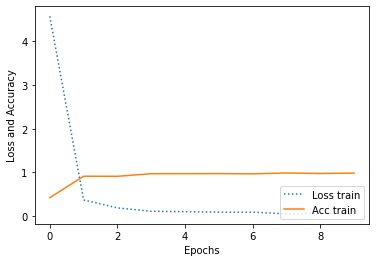

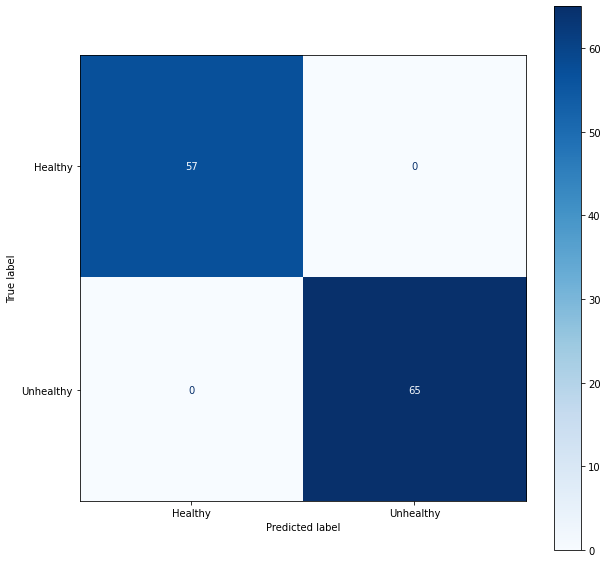

In [ ]:
#B
#Use of fused dataset so it can have a balanced number of healthy and unhealty images
#With Data Augmentation to increase dataset

log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

learning_rate = 1e-3
batch_size = 15
num_cicles = 1
num_epochs = 10

#transform to random rotate
transformsRotation = transforms.Compose([
  transforms.RandomRotation(degrees=(-90, 90)),
  transforms.ToTensor()
])
#transform to add blur
transformsBlur = transforms.Compose([
  transforms.GaussianBlur(kernel_size=(5, 5), sigma=3),
  transforms.ToTensor()
])

#rotate transform dataset
datasetRotation = LettuceDataset(
    csv_file = "lettuces 2 Classes.csv",
    root_dir = "Dataset 2 Classes",
    transform = transformsRotation
)
#blur transform dataset
datasetBlur = LettuceDataset(
    csv_file = "lettuces 2 Classes.csv",
    root_dir = "Dataset 2 Classes",
    transform = transformsBlur
)
#original dataset
dataset  = LettuceDataset(
    csv_file = "lettuces 2 Classes.csv",
    root_dir = "Dataset 2 Classes",
    transform = transforms.ToTensor()
)

#concat to increase dataset images; The dataset is increased 3x the original lenght. Rotation dataset + Blur dataset + Original dataset = 606 images
dataset = torch.utils.data.ConcatDataset([dataset, datasetRotation, datasetBlur])

#print(len(dataset)) #606

train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
trainLoader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=1)
testLoader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=1)

classes1 = {"Healthy", "Unhealthy"}

model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')

# Define the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

model = model.to(device)

#print(model)

print("--------------------Training----------------------")
best_loss, best_accuracy, best_epoch = train(model=model, 
                                                dataloader=trainLoader, 
                                                loss_fn=loss_fn, 
                                                optimizer=optimizer,
                                                device=device,
                                                num_cicles=num_cicles,
                                                num_epochs = num_epochs,
                                                path_model = str("./myModel_best.pth"), 
                                                verbatim = True)

print("--------------------Testing----------------------")
y_pred, test_loss, test_acc  = test(model=model, 
                                    dataloader=testLoader, 
                                    loss_fn=loss_fn, 
                                    device=device, 
                                    verbatim = True)

print("")
print("Checking accuracy on Training Set\n")
check_accuracy(trainLoader, model)

print("Checking accuracy on Test Set\n")
check_accuracy(testLoader, model)

plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_train_acc, label='Acc train')
plt.legend(loc='lower right')
plt.show()

print("")

images, labels, probs = get_predictions(model, testLoader,  device)
pred_labels = torch.argmax(probs, 1)    

plot_confusion_matrix(labels, pred_labels, classes1)


**Parte 2**

**Classificação de Doenças nas folhas das alfaces em 6 classes (Healthy, Downy Mildew, Bacterial, Powdery Mildew, Septoria Blight, Wilt and Leaf Blight)**

Foi utilizado o Resnet50 como modelo para a rede, com cross entropy para cálculo da loss e SGD como optimizer tal como no parte 1.


--------------------Training----------------------
----------------- Cicle  0  of  5  -----------------
----------------- Epoch  0  of  10  -----------------
Train Loss:  6.937753404889788 Train Accuracy:  0.0
----------------- Epoch  1  of  10  -----------------
Train Loss:  6.663759504045759 Train Accuracy:  0.009523809523809523
----------------- Epoch  2  of  10  -----------------
Train Loss:  6.187140532902309 Train Accuracy:  0.10476190476190476
----------------- Epoch  3  of  10  -----------------
Train Loss:  5.489416803632464 Train Accuracy:  0.1880952380952381
----------------- Epoch  4  of  10  -----------------
Train Loss:  4.806179523468018 Train Accuracy:  0.3404761904761905
----------------- Epoch  5  of  10  -----------------
Train Loss:  3.957075766154698 Train Accuracy:  0.5095238095238095
----------------- Epoch  6  of  10  -----------------
Train Loss:  3.095289741243635 Train Accuracy:  0.6785714285714286
----------------- Epoch  7  of  10  -----------------
Train L

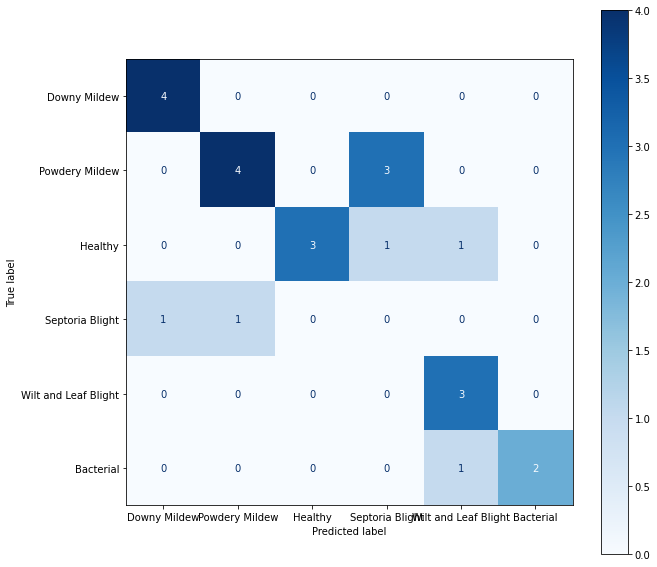

In [ ]:
#Without Data augmentation

learning_rate = 1e-3
batch_size = 15
num_cicles = 5
num_epochs = 10

torch.manual_seed(17)

dataset = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transforms.ToTensor()
)

#print(len(dataset))

train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
trainLoader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, num_workers=1)
testLoader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, num_workers=1)

classes2 = {"Healthy", "Downy Mildew", "Bacterial", "Powdery Mildew", "Septoria Blight", "Wilt and Leaf Blight"}


model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')

loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
model_aug = model.to(device)

print("--------------------Training----------------------")
best_loss, best_accuracy, best_epoch = train(model=model_aug, 
                                                    dataloader = trainLoader, 
                                                    loss_fn = loss_fn, 
                                                    optimizer = optimizer,
                                                    device = device,
                                                    num_cicles = num_cicles,
                                                    num_epochs = num_epochs,
                                                    path_model = str("./myModel_best_aug.pth"), 
                                                    verbatim = True)

print("--------------------Testing----------------------")
y_pred, test_loss, test_acc  = test(model=model_aug, 
                                        dataloader=testLoader, 
                                        loss_fn=loss_fn, 
                                        device=device, 
                                        verbatim = True)


print("Checking accuracy on Training Set")
check_accuracy(trainLoader, model)

print("Checking accuracy on Test Set")
check_accuracy(testLoader, model)

# Test the model using all testset
images, labels, probs = get_predictions(model_aug, testLoader,  device)
pred_labels = torch.argmax(probs, 1)    
    
plot_confusion_matrix(labels, pred_labels, classes2)


2


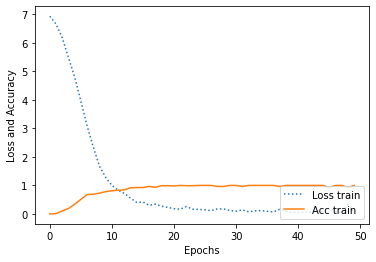

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_train_acc, label='Acc train')
plt.legend(loc='lower right')
plt.show()

590
--------------------Training----------------------
----------------- Cicle  0  of  5  -----------------
----------------- Epoch  0  of  10  -----------------
Train Loss:  6.568765759468079 Train Accuracy:  0.02569444444444444
----------------- Epoch  1  of  10  -----------------
Train Loss:  4.721032480398814 Train Accuracy:  0.25763888888888886
----------------- Epoch  2  of  10  -----------------
Train Loss:  2.415553316473961 Train Accuracy:  0.5618055555555556
----------------- Epoch  3  of  10  -----------------
Train Loss:  1.1307353725035985 Train Accuracy:  0.7291666666666666
----------------- Epoch  4  of  10  -----------------
Train Loss:  0.7177753920356432 Train Accuracy:  0.8222222222222221
----------------- Epoch  5  of  10  -----------------
Train Loss:  0.5666631671289603 Train Accuracy:  0.8375
----------------- Epoch  6  of  10  -----------------
Train Loss:  0.4297708831727505 Train Accuracy:  0.9069444444444444
----------------- Epoch  7  of  10  ---------------

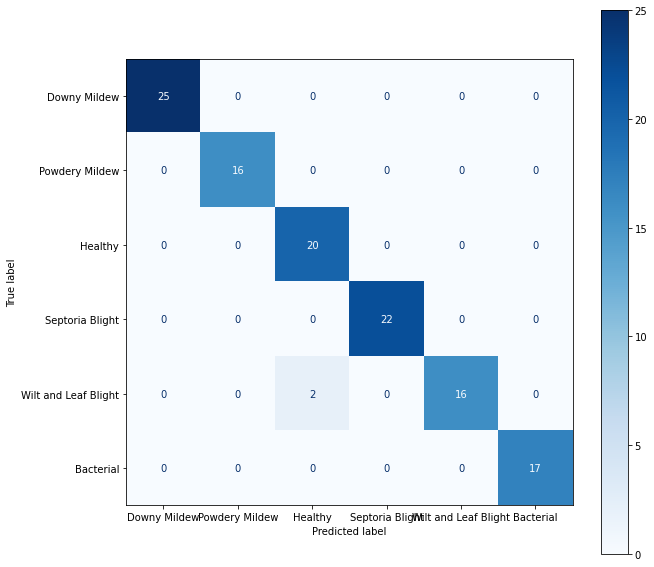

In [ ]:
#With Data augmentation 

log_train_loss = []
log_train_acc = []
log_val_loss = []
log_val_acc = []

learning_rate = 1e-3
batch_size = 20
num_cicles = 5
num_epochs = 10

torch.manual_seed(17)

transformsRotation = transforms.Compose([
  transforms.RandomRotation(degrees=(-90, 90)),
  transforms.ToTensor()
])
transformsBlur = transforms.Compose([
  transforms.GaussianBlur(kernel_size=(5, 5), sigma=3),
  transforms.ToTensor()
])
transformsColor = transforms.Compose([
  transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0, hue=0),
  transforms.ToTensor()
])
transformsSharp = transforms.Compose([
  transforms.RandomAdjustSharpness(2, 0.9),
  transforms.ToTensor()
])

datasetRotation = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transformsRotation
)
datasetBlur = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transformsBlur
)
datasetColor = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transformsRotation
)
datasetSharp = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transformsBlur
)
dataset = LettuceDataset(
    csv_file = "lettuces 5 Classes.csv",
    root_dir = "Dataset 5 Classes",
    transform = transforms.ToTensor()
)

#concat to increase dataset images
datasetAug = torch.utils.data.ConcatDataset([dataset, datasetRotation, datasetBlur, datasetColor, datasetSharp])

print(len(datasetAug)) #now 590

train_set_aug, test_set_aug = torch.utils.data.random_split(datasetAug, [int(0.8*len(datasetAug)), len(datasetAug)-int(0.8*len(datasetAug))])
trainLoaderAug = DataLoader(dataset=train_set_aug, batch_size=batch_size, shuffle=True, num_workers=2)
testLoaderAug = DataLoader(dataset=test_set_aug, batch_size=batch_size, shuffle=True, num_workers=2)

classes2 = {"Healthy", "Downy Mildew", "Bacterial", "Powdery Mildew", "Septoria Blight", "Wilt and Leaf Blight"}


model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT')

loss_fn = nn.CrossEntropyLoss().to(device)

optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        
model_aug = model.to(device)

print("--------------------Training----------------------")
best_loss, best_accuracy, best_epoch = train(model=model_aug, 
                                                    dataloader = trainLoaderAug, 
                                                    loss_fn = loss_fn, 
                                                    optimizer = optimizer,
                                                    device = device,
                                                    num_cicles = num_cicles,
                                                    num_epochs = num_epochs,
                                                    path_model = str("./myModel_best_aug.pth"), 
                                                    verbatim = True)

print("--------------------Testing----------------------")
y_pred, test_loss, test_acc  = test(model=model_aug, 
                                        dataloader=testLoaderAug, 
                                        loss_fn=loss_fn, 
                                        device=device, 
                                        verbatim = True)


print("Checking accuracy on Training Set")
check_accuracy(trainLoaderAug, model)

print("Checking accuracy on Test Set")
check_accuracy(testLoaderAug, model)

# Test the model using all testset
images, labels, probs = get_predictions(model_aug, testLoaderAug,  device)
pred_labels = torch.argmax(probs, 1)    
    
plot_confusion_matrix(labels, pred_labels, classes2)

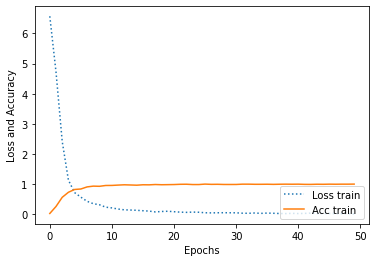

In [ ]:
plt.xlabel("Epochs")
plt.ylabel("Loss and Accuracy")
plt.plot(log_train_loss, linestyle = 'dotted',  label='Loss train')
plt.plot(log_train_acc, label='Acc train')
plt.legend(loc='lower right')
plt.show()

**Conclusão**

Para concluir, é de realçar o facto que a dimensão do dataset e o número desigual de imagens entre classes são fatores cruciais para o desempenho da rede.

Inicialmente, para distinguir uma alface não saudável de uma saudável foi utilizado um dataset onde o número desiquilibrado de imagens entre classes (98/20) não mostrou ser um factor relevante para o mau desempenho da rede. Assim, com a adição de 84 imagens de alfaces saudáveis, a desigualdade desapareceu e o modelo continuou robusto, com uma accuracy elevada.

Na parte 2, o baixo número de imagens de input à rede mostrou ser um parâmetro negativo para o desempenho da mesma. Com o aumento, através do recurso a data augmentation, a rede passou a ter mais informação para ser treinada aumentando assim a sua performance.


**Artigos**

1 - https://www.mdpi.com/2077-0472/12/8/1192/pdf (Convolutional Neural Networks in Detection of Plant Leaf Diseases: A Review)

2 - https://www.frontiersin.org/articles/10.3389/fpls.2022.874035/full (Detection and Localization of Tip-Burn on Large Lettuce Canopies)
